In [1]:
# ============================
# Import Libraries
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Proper import for dataset
from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)


In [2]:
# ================================================================
# PART A — Baseline Model (Decision Stump)
# ================================================================

# 1️⃣ Load the dataset from sklearn.datasets (UCI Heart Disease)
heart = fetch_openml(name="heart-disease", version=1, as_frame=True)
df = heart.frame

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0


In [3]:
# 2️⃣ Split features and target
X = df.drop(columns=["target"])
y = df["target"].astype(int)  # ensure target is 0/1 integers

# Identify categorical features
cat_cols = [col for col in X.columns if X[col].dtype == 'category' or X[col].dtype == 'object']
print("Categorical features:", cat_cols)

# Convert categorical columns using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# 3️⃣ Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


Categorical features: []


Decision Stump — Performance
Train Accuracy: 0.773
Test Accuracy: 0.705

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        28
           1       0.73      0.73      0.73        33

    accuracy                           0.70        61
   macro avg       0.70      0.70      0.70        61
weighted avg       0.70      0.70      0.70        61



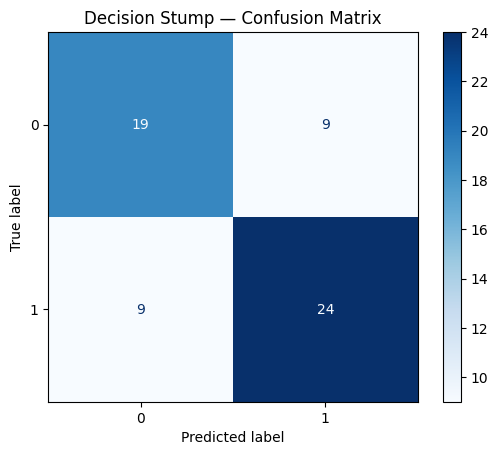


🧩 Observation:
A single stump can only split once, so it cannot model complex relationships among medical features like cholesterol, age, and chest pain type.


In [4]:
# 5️⃣ Baseline: Decision Stump (max_depth = 1)
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

# 6️⃣ Metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Decision Stump — Performance")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Decision Stump — Confusion Matrix")
plt.show()

print("\n🧩 Observation:")
print("A single stump can only split once, so it cannot model complex relationships "
      "among medical features like cholesterol, age, and chest pain type.")


,learning_rate,n_estimators,test_accuracy
0,0.1,5,0.704918
1,0.1,10,0.737705
2,0.1,25,0.819672
3,0.1,50,0.803279
4,0.1,100,0.852459
5,0.5,5,0.819672
6,0.5,10,0.852459
7,0.5,25,0.836066
8,0.5,50,0.836066
9,0.5,100,0.819672


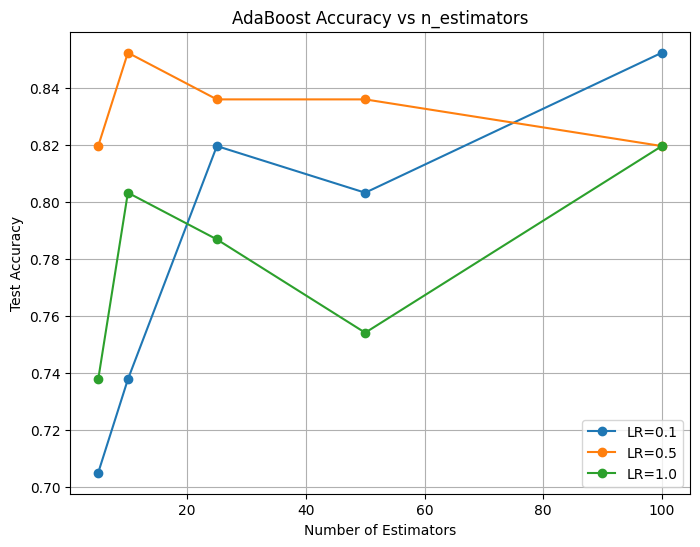


🏆 Best Configuration:
learning_rate      0.100000
n_estimators     100.000000
test_accuracy      0.852459
Name: 4, dtype: float64


In [5]:
# ================================================================
# PART B — AdaBoost with Decision Stumps
# ================================================================
n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = []

for lr in learning_rates:
    for n_est in n_estimators_list:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((lr, n_est, acc))

results_df = pd.DataFrame(results, columns=["learning_rate", "n_estimators", "test_accuracy"])
display(results_df)

# Plot results
plt.figure(figsize=(8,6))
for lr in learning_rates:
    subset = results_df[results_df.learning_rate == lr]
    plt.plot(subset["n_estimators"], subset["test_accuracy"], marker='o', label=f"LR={lr}")
plt.xlabel("Number of Estimators")
plt.ylabel("Test Accuracy")
plt.title("AdaBoost Accuracy vs n_estimators")
plt.legend()
plt.grid(True)
plt.show()

best_row = results_df.loc[results_df["test_accuracy"].idxmax()]
print("\n🏆 Best Configuration:")
print(best_row)


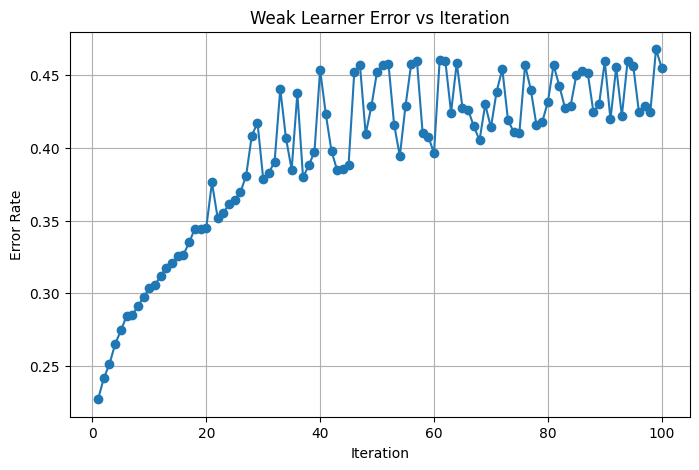

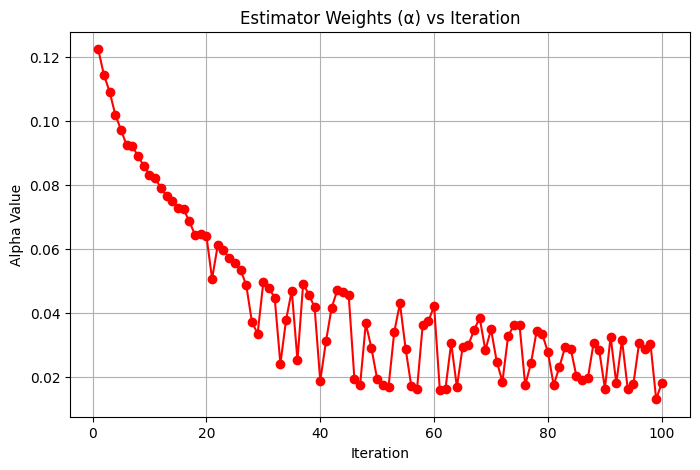


🧠 Interpretation:
Samples that are repeatedly misclassified receive higher weights, forcing AdaBoost to focus on these 'hard' cases (borderline medical profiles).


In [6]:
# ================================================================
# PART C — Misclassification Pattern (Best Model)
# ================================================================
best_lr = best_row.learning_rate
best_n = int(best_row.n_estimators)

best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr,
    random_state=42
)
best_model.fit(X_train, y_train)

# Plot weak learner errors
plt.figure(figsize=(8,5))
plt.plot(range(1, len(best_model.estimator_errors_)+1), best_model.estimator_errors_, marker='o')
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error Rate")
plt.grid(True)
plt.show()

# Plot alpha (estimator weights)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(best_model.estimator_weights_)+1), best_model.estimator_weights_, marker='o', color='red')
plt.title("Estimator Weights (α) vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha Value")
plt.grid(True)
plt.show()

print("\n🧠 Interpretation:")
print("Samples that are repeatedly misclassified receive higher weights, "
      "forcing AdaBoost to focus on these 'hard' cases (borderline medical profiles).")


C:\Users\Smarth Kaushal\AppData\Local\Temp\ipykernel_17864\2280462102.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_importances, y=top5_features, palette="Reds_r")


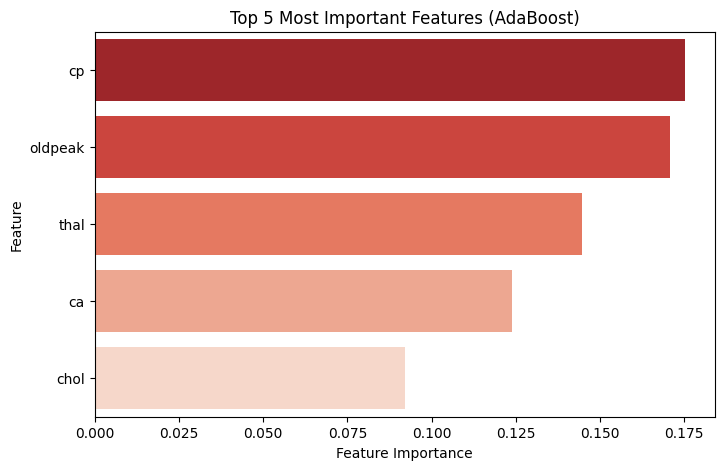


💡 Medical Interpretation:
- cp: Chest pain type is a key clinical symptom of heart issues.
- oldpeak: ST depression during exercise indicates stress on the heart.
- chol: High cholesterol leads to arterial plaque buildup.


In [7]:
# ================================================================
# PART D — Feature Importance & Medical Insight
# ================================================================
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

top5_idx = indices[:5]
top5_features = np.array(X.columns)[top5_idx]
top5_importances = importances[top5_idx]

plt.figure(figsize=(8,5))
sns.barplot(x=top5_importances, y=top5_features, palette="Reds_r")
plt.title("Top 5 Most Important Features (AdaBoost)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

print("\n💡 Medical Interpretation:")
for f in top5_features:
    if "age" in f.lower():
        print(f"- {f}: Older age increases heart disease risk due to arterial stiffening.")
    elif "thalach" in f.lower():
        print(f"- {f}: Maximum heart rate achieved indicates cardiovascular performance.")
    elif "chol" in f.lower():
        print(f"- {f}: High cholesterol leads to arterial plaque buildup.")
    elif "cp" in f.lower():
        print(f"- {f}: Chest pain type is a key clinical symptom of heart issues.")
    elif "oldpeak" in f.lower():
        print(f"- {f}: ST depression during exercise indicates stress on the heart.")
